In [74]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
datapath = os.getcwd()
print(datapath)
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
#設定所有欄看的見
pd.set_option('display.max_columns', None)
#資料載入
datapath = r"C:\Users\user\Documents\Competition data\資料集"
df_train = pd.read_csv(os.path.join(datapath,'house_train.csv.gz'))
df_test = pd.read_csv(os.path.join(datapath,'house_test.csv.gz'))

C:\Users\user\Documents\Competition data\house_predict


In [75]:
#價格以log方式壓縮
ori_train_Y = np.log1p(df_train['SalePrice'])
#ID
ids = df_test['Id']
#訓練時將ID與輸出剃除
df_train = df_train.drop(['Id', 'SalePrice'] , axis=1)
df_test = df_test.drop(['Id'] , axis=1)

#剔除oulier
#df_train = df_train[df_train.GrLivArea < 4500]
#df_train.reset_index(drop=True, inplace=True)

#先合併做前處理
df = pd.concat([df_train, df_test])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [76]:
def check_miss(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(20))

In [77]:
check_miss(df_train)

              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
LotConfig         0  0.000000


In [78]:
check_miss(df_test)

              Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageCond       78  0.053461
GarageFinish     78  0.053461
GarageYrBlt      78  0.053461
GarageQual       78  0.053461
GarageType       76  0.052090
BsmtCond         45  0.030843
BsmtExposure     44  0.030158
BsmtQual         44  0.030158
BsmtFinType1     42  0.028787
BsmtFinType2     42  0.028787
MasVnrType       16  0.010966
MasVnrArea       15  0.010281
MSZoning          4  0.002742
BsmtHalfBath      2  0.001371


In [79]:
df_train[df_train['GrLivArea']>4500]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial


In [80]:
df_test[df_test['GrLivArea']>4500]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1089,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,NaN,17000,10,2007,New,Partial


In [81]:
Garge_cols=['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
Bstm_cols=['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

In [82]:
#Functional: Home functionality (Assume typical unless deductions are warranted)
df['Functional']=df['Functional'].fillna('Typ')
#missing時預設為標準型
df['Electrical']=df['Electrical'].fillna('SBrkr')

In [83]:
# 部分欄位缺值補 'None'
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'FireplaceQu', 'FireplaceQu', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass']
#類別損失值以None代替
for col in none_cols:
    df[col] = df[col].fillna("None")
# 數值部分欄位缺值填補 0
#因代表沒有
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
             'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
for col in zero_cols:
    df[col] = df[col].fillna(0)

In [84]:
# 數值部分欄位缺值補眾數
mode_cols = ['KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
df['MSZoning']=df.groupby('MSSubClass')['MSZoning'].transform(lambda x:x.fillna(x.mode()[0]))
# 'LotFrontage' 有空缺時, 以同一區 (Neighborhood) 的 LotFrontage 中位數填補 (可以視為填補一種群聚編碼 )
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
# Utilities 參考資訊很少, 所以直接捨棄
df = df.drop(['Utilities'], axis=1)

In [85]:
def seqEnocder(df,col):
    def trans(x,dict_):
        t = dict_.get(x)
        return t
    seq = df[col]
    sort_ =np.sort(seq.unique())
    dict_ = {value_:index_+1 for index_,value_ in enumerate(sort_) }
    df[col] = seq.map(lambda x:trans(x,dict_))
def seqEnocder_1(df,col):
    def trans(x,dict_):
        t = dict_.get(x)
        return t
    seq = df[col]
    sort_ =np.sort(seq.unique())
    dict_ ={'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0,'None':0}
    df[col] = seq.map(lambda x:trans(x,dict_))
def seqEnocder_2(df,col):
    def trans(x,dict_):
        t = dict_.get(x)
        return t
    seq = df[col]
    sort_ =np.sort(seq.unique())
    dict_ ={'GLQ':4,'ALQ':3,'BLQ':2,'Rec':1,'LwQ':0,'Unf':0,'NA':0,'None':0}
    df[col] = seq.map(lambda x:trans(x,dict_))

In [86]:
# 四個數值欄位, 因為相異值有限, 轉成文字
'''
label_cols = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
for col in mode_cols:
    df[col] = df[col].astype(str)
'''

"\nlabel_cols = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']\nfor col in mode_cols:\n    df[col] = df[col].astype(str)\n"

In [87]:
check_miss(df)

               Total  Percent
SaleCondition      0      0.0
BsmtQual           0      0.0
Exterior1st        0      0.0
Exterior2nd        0      0.0
MasVnrType         0      0.0
MasVnrArea         0      0.0
ExterQual          0      0.0
ExterCond          0      0.0
Foundation         0      0.0
BsmtCond           0      0.0
RoofStyle          0      0.0
BsmtExposure       0      0.0
BsmtFinType1       0      0.0
BsmtFinSF1         0      0.0
BsmtFinType2       0      0.0
BsmtFinSF2         0      0.0
BsmtUnfSF          0      0.0
TotalBsmtSF        0      0.0
RoofMatl           0      0.0
YearRemodAdd       0      0.0


In [88]:
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal


In [89]:
'''
月特徵增加四季特徵
MSSubClass、YrSold、MoSold轉成文字型態
轉化ExterQual、ExterCond、HeatingQC、BsmtFinType1、BsmtFinType2為序列分數
將LotArea分級
增加品質特徵、房屋總面積、總廁所數、浴室分數
品質特徵:

'''

'\n月特徵增加四季特徵\nMSSubClass、YrSold、MoSold轉成文字型態\n轉化ExterQual、ExterCond、HeatingQC、BsmtFinType1、BsmtFinType2為序列分數\n將LotArea分級\n增加品質特徵、房屋總面積、總廁所數、浴室分數\n品質特徵:\n\n'

In [90]:
#特徵前處理
import copy
fea_df = copy.deepcopy(df)

In [91]:
def season(x):
    if x>=4 and x<7 :
        x='Spring'
    elif x>= 7 and x<10:
        x='Summer'
    elif x>= 10 and x<13:
        x='Fall'
    else:
        x="Winter"
    return x

In [92]:
#月份分四季
fea_df['Season'] = fea_df['MoSold'].map(lambda x:season(x))

In [93]:
# 四個數值欄位, 因為相異值有限, 轉成文字
label_cols = ['MSSubClass','MoSold','YearBuilt','GarageYrBlt']#房型跟月份
for col in label_cols:
    fea_df[col] = fea_df[col].astype(str)

In [94]:
#特徵衍生
#總房屋面積
fea_df['TotalSF'] = fea_df['TotalBsmtSF']+fea_df['1stFlrSF']+ fea_df['2ndFlrSF'] 
#總廁所數
fea_df['TotalBath'] = fea_df['BsmtFullBath']+fea_df['BsmtHalfBath']+fea_df['FullBath']+fea_df['HalfBath']
fea_df['TotalBath_score'] = 2*fea_df['BsmtFullBath']+1*fea_df['BsmtHalfBath']+3*fea_df['FullBath']+1*fea_df['HalfBath']
fea_df['Total_porch_sf'] = (fea_df['OpenPorchSF'] + fea_df['3SsnPorch'] +
                              fea_df['EnclosedPorch'] + fea_df['ScreenPorch'] +
                              fea_df['WoodDeckSF'])

In [95]:
trespilt = np.linspace(10000,50000,5)
#trespilt=list(range(10000,50000,10000))
def trelotarea(x,trespilt):
    if x <= trespilt[0]:
        x = 1
    elif x >trespilt[0] and x <= trespilt[1]:
        x=2
    elif x >trespilt[1] and x <= trespilt[2]:
        x=3
    elif x >trespilt[2] and x <= trespilt[3]:
        x=4
    else:
        x=5
    return x 

In [96]:
#將土地面積分級
fea_df['LotArea_grade']=fea_df['LotArea'].map(lambda x:(trelotarea(x,trespilt)))

In [97]:
#序列轉換
#seqEnocder(fea_df,'MSSubClass')
#品質轉換
Qual_cols=['ExterQual','ExterCond','HeatingQC','BsmtQual','BsmtCond','KitchenQual','FireplaceQu','GarageQual','GarageCond'
          ,'PoolQC']
for qcol in Qual_cols:
    seqEnocder_1(fea_df,qcol)

seqEnocder_2(fea_df,'BsmtFinType1')
seqEnocder_2(fea_df,'BsmtFinType2')

In [98]:
#裝修品質
#OverallQual整體裝修材料*OverallCond整體裝修
fea_df['Qual_Overall']=fea_df['OverallQual']*fea_df['OverallCond']
fea_df['Qual_Exter']=fea_df['ExterQual']*fea_df['ExterCond']
fea_df['Qual_Bsmt'] = fea_df['BsmtQual']*fea_df['BsmtCond']
fea_df['Qual_BsmtFinSF1'] = fea_df['BsmtFinType1']*fea_df['BsmtFinSF1']
fea_df['Qual_BsmtFinSF2'] = fea_df['BsmtFinType2']*fea_df['BsmtFinSF2']
fea_df['Qual_ALLBsmt'] = fea_df['Qual_Bsmt']*(fea_df['Qual_BsmtFinSF1']+fea_df['Qual_BsmtFinSF2'])
fea_df['Qual_SF']=fea_df['TotalBsmtSF']+2*fea_df['1stFlrSF']+ fea_df['2ndFlrSF'] -fea_df['LowQualFinSF']
fea_df['Qual_Kitchen'] = fea_df['KitchenAbvGr']*fea_df['KitchenQual']
fea_df['Qual_Fireplace']=fea_df['Fireplaces']*fea_df['FireplaceQu']
fea_df['Qual_Garage']=fea_df['GarageQual']*fea_df['GarageCond']
fea_df['Qual_Garagearea']=fea_df['GarageQual']*fea_df['GarageCond']*fea_df['GarageArea']
fea_df['Qual_pool']=fea_df['PoolArea']*fea_df['PoolQC']

In [99]:
#具有物
fea_df['haspool']=fea_df['PoolArea'].apply(lambda x: 1 if x>0 else 0)
fea_df['has2ndfloor'] = fea_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
fea_df['hasgarage'] = fea_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
fea_df['hasbsmt'] = fea_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
fea_df['hasfireplace'] = fea_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
#二值化
fea_df['CentralAir']=fea_df['CentralAir'].apply(lambda x:1 if x=='Y' else 0)
fea_df['newhouse']=fea_df['SaleType'].apply(lambda x:1 if x=='New' else 0)
fea_df['Abnsale'] = fea_df['SaleCondition'].apply(lambda x:1 if x=='Abnorml'else 0)

In [100]:
fea_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Season,TotalSF,TotalBath,TotalBath_score,Total_porch_sf,LotArea_grade,Qual_Overall,Qual_Exter,Qual_Bsmt,Qual_BsmtFinSF1,Qual_BsmtFinSF2,Qual_ALLBsmt,Qual_SF,Qual_Kitchen,Qual_Fireplace,Qual_Garage,Qual_Garagearea,Qual_pool,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,newhouse,Abnsale
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,2,PConc,3,2,No,4,706.0,0,0.0,150.0,856.0,GasA,4,1,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,3,8,Typ,0,0,Attchd,2003.0,RFn,2.0,548.0,2,2,Y,0,61,0,0,0,0,0,None,None,0,2,2008,WD,Normal,Winter,2566.0,4.0,9.0,61,1,35,6,6,2824.0,0.0,16944.0,3422.0,3,0,4,2192.0,0,0,1,1,1,0,0,0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,CBlock,3,2,Gd,3,978.0,0,0.0,284.0,1262.0,GasA,4,1,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,2,6,Typ,1,2,Attchd,1976.0,RFn,2.0,460.0,2,2,Y,298,0,0,0,0,0,0,None,None,0,5,2007,WD,Normal,Spring,2524.0,3.0,7.0,298,1,48,4,6,2934.0,0.0,17604.0,3786.0,2,2,4,1840.0,0,0,0,1,1,1,0,0
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,2,PConc,3,2,Mn,4,486.0,0,0.0,434.0,920.0,GasA,4,1,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,3,6,Typ,1,2,Attchd,2001.0,RFn,2.0,608.0,2,2,Y,0,42,0,0,0,0,0,None,None,0,9,2008,WD,Normal,Summer,2706.0,4.0,9.0,42,2,35,6,6,1944.0,0.0,11664.0,3626.0,3,2,4,2432.0,0,0,1,1,1,1,0,0
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,2,3,No,3,216.0,0,0.0,540.0,756.0,GasA,3,1,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,3,7,Typ,1,3,Detchd,1998.0,Unf,3.0,642.0,2,2,Y,0,35,272,0,0,0,0,None,None,0,2,2006,WD,Abnorml,Winter,2473.0,2.0,5.0,307,1,35,4,6,648.0,0.0,3888.0,3434.0,3,3,4,2568.0,0,0,1,1,1,1,0,1
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,2,PConc,3,2,Av,4,655.0,0,0.0,490.0,1145.0,GasA,4,1,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,3,9,Typ,1,2,Attchd,2000.0,RFn,3.0,836.0,2,2,Y,192,84,0,0,0,0,0,None,None,0,12,2008,WD,Normal,Fall,3343.0,4.0,9.0,276,2,40,6,6,2620.0,0.0,15720.0,4488.0,3,2,4,3344.0,0,0,1,1,1,1,0,0


In [101]:
#將資料分為數值、二元、類別型態
#數值型態需做偏態確認，有偏態時需做常態

In [102]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
objecttype= []
bionum=[]
for i in fea_df.columns:
    if fea_df[i].dtype in numeric_dtypes:
        if len(fea_df[i].unique())==2:
            bionum.append(i)
        else:
            numerics2.append(i)
    elif fea_df[i].dtype =='object':
        objecttype.append(i)

In [103]:
len(objecttype),len(bionum),len(numerics2)

(34, 8, 61)

In [104]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler() #z-scaler物件

In [105]:
#fea_df['MiscVal']=np.log1p(fea_df['MiscVal'])
#fea_df['PoolArea']=np.log1p(fea_df['PoolArea'])
#偏態測試
skew_features = fea_df[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
#正負偏態大於0.5視為偏態
high_skew = skew_features[abs(skew_features) > 0.5]
skew_index = high_skew.index
for i in skew_index:
    fea_df[i] = boxcox1p(fea_df[i], boxcox_normmax(fea_df[i] + 1))
    #fea_df[i] = np.log1p(fea_df[i])

In [106]:
#fea_df = fea_df.drop(['Qual_pool', 'PoolQC', 'PoolArea',], axis=1)

In [107]:
#one-hot EN
fea_df = pd.get_dummies(fea_df)
print(fea_df.shape)

(2919, 521)


In [108]:
fea_df.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold,TotalSF,TotalBath,TotalBath_score,Total_porch_sf,LotArea_grade,Qual_Overall,Qual_Exter,Qual_Bsmt,Qual_BsmtFinSF1,Qual_BsmtFinSF2,Qual_ALLBsmt,Qual_SF,Qual_Kitchen,Qual_Fireplace,Qual_Garage,Qual_Garagearea,Qual_pool,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,newhouse,Abnsale,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1879,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1895,YearBuilt_1896,YearBuilt_1898,YearBuilt_1900,YearBuilt_1901,YearBuilt_1902,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1907,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,Yea

In [109]:
#利用歐式距離分群，須將數值壓制0,1之間
Kfea_df = copy.deepcopy(fea_df)
from sklearn.preprocessing import MinMaxScaler
MMscaler = MinMaxScaler()
Kfea_df[Kfea_df.columns] = MMscaler.fit_transform(Kfea_df[Kfea_df.columns])
Kfea_df.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold,TotalSF,TotalBath,TotalBath_score,Total_porch_sf,LotArea_grade,Qual_Overall,Qual_Exter,Qual_Bsmt,Qual_BsmtFinSF1,Qual_BsmtFinSF2,Qual_ALLBsmt,Qual_SF,Qual_Kitchen,Qual_Fireplace,Qual_Garage,Qual_Garagearea,Qual_pool,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,newhouse,Abnsale,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1879,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1895,YearBuilt_1896,YearBuilt_1898,YearBuilt_1900,YearBuilt_1901,YearBuilt_1902,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1907,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,Yea

In [110]:
#有問題時把TEAR都改成類別資料

In [111]:
##Kmeans 分群
from sklearn.cluster import KMeans
for i in range(3,11,2):
    KM = KMeans(n_clusters=i)
    KM.fit(Kfea_df)
    name='KM'+str(i)
    fea_df[name]=KM.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [112]:
fea_df.head(10)

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold,TotalSF,TotalBath,TotalBath_score,Total_porch_sf,LotArea_grade,Qual_Overall,Qual_Exter,Qual_Bsmt,Qual_BsmtFinSF1,Qual_BsmtFinSF2,Qual_ALLBsmt,Qual_SF,Qual_Kitchen,Qual_Fireplace,Qual_Garage,Qual_Garagearea,Qual_pool,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,newhouse,Abnsale,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1879,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1895,YearBuilt_1896,YearBuilt_1898,YearBuilt_1900,YearBuilt_1901,YearBuilt_1902,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1907,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,Yea

In [113]:
#group特徵
gro_df = copy.deepcopy(fea_df)
train_num = ori_train_Y.shape[0]
gro_df_train = gro_df[:train_num]
gro_df_test = gro_df[train_num:]

In [114]:
#合併saleprice
gro_df_train = pd.concat([gro_df_train,ori_train_Y],axis=1)
gro_df_train.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold,TotalSF,TotalBath,TotalBath_score,Total_porch_sf,LotArea_grade,Qual_Overall,Qual_Exter,Qual_Bsmt,Qual_BsmtFinSF1,Qual_BsmtFinSF2,Qual_ALLBsmt,Qual_SF,Qual_Kitchen,Qual_Fireplace,Qual_Garage,Qual_Garagearea,Qual_pool,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,newhouse,Abnsale,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1879,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1895,YearBuilt_1896,YearBuilt_1898,YearBuilt_1900,YearBuilt_1901,YearBuilt_1902,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1907,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,Yea

In [115]:
gro_col=['LotFrontage','OverallQual','OverallCond','TotalBath']
for gro in gro_col:
    a=gro_df_train['SalePrice'].groupby(gro_df_train[gro]).mean()
    a.name='mean_'+gro+'_SP'
    gro_df_train=pd.merge(gro_df_train,a,on=gro,how='left')
    gro_df_test=pd.merge(gro_df_test,a,on=gro,how='left')

In [116]:
##特徵處理完，分割數據集
train_num = ori_train_Y.shape[0]
ori_train_X = fea_df[:train_num]
ori_test_X = fea_df[train_num:]

In [117]:
gro_df_train= gro_df_train.drop('SalePrice',axis=1)

In [118]:
ori_train_X=gro_df_train
ori_test_X=gro_df_test

In [119]:
ori_train_X.shape

(1460, 529)

In [120]:
#刪掉預測後爛的index
badindex=[1298, 1324, 812, 916, 968, 970, 410, 462, 495, 523, 632, 688, 30]
ori_train_X=ori_train_X.drop(ori_train_X.index[badindex])
ori_train_Y=ori_train_Y.drop(ori_train_Y.index[badindex])

In [121]:
from xgboost import XGBRegressor
random_state=[20,33,44,88,100]
clf = XGBRegressor(object ='reg:squarederror')

In [122]:
clf

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, object='reg:squarederror',
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [123]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4)
kf.get_n_splits(ori_train_X)

4

In [124]:
X=ori_train_X.values
y=ori_train_Y.values
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [125]:
'''
feature_names=gro_df_train.columns
dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=feature_names)
dvalid = xgb.DMatrix(X_test, label=y_test,feature_names=feature_names)
'''

'\nfeature_names=gro_df_train.columns\ndtrain = xgb.DMatrix(X_train, label=y_train,feature_names=feature_names)\ndvalid = xgb.DMatrix(X_test, label=y_test,feature_names=feature_names)\n'

In [126]:
import xgboost as xgb
xgb_pars = {'min_child_weight': 10, 'eta': 0.2, 'colsample_bytree': 0.8, 'max_depth': 3,
            'subsample': 0.9, 'lambda': 2, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'gamma' : 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'} 
def lear(X_train,X_test,y_train,y_test,savenum):
    feature_names=gro_df_train.columns
    dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=feature_names)
    dvalid = xgb.DMatrix(X_test, label=y_test,feature_names=feature_names)
    dtest = xgb.DMatrix(ori_test_X.values,feature_names=feature_names)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(xgb_pars, dtrain,1000, watchlist, early_stopping_rounds=100,
                  maximize=False, verbose_eval=50)
    #使用最好的代數去預測
    #get predictions from the best iteration with bst.best_ntree_limit
    #predict=model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    predict=model.predict(dvalid)
    tp = pd.DataFrame(data={'ytest':y_test,'predict':predict},index=test_index)
    tp['bias']=tp['ytest']-tp['predict']
    badpre = copy.deepcopy(tp[abs(tp['bias'])>0.5])
    rmse = np.sqrt(mse(y_test,predict))
    plt.figure()
    plt.xlim(10,14)
    plt.ylim(10,14)
    sns.scatterplot(y_test,predict)
    sns.lineplot(y_test,predict,color='r')
    plt.xlabel('y_test')
    plt.ylabel('predict')
    plt.show()
    gain=pd.DataFrame(model.get_score(importance_type='gain').items(), columns=['feature','gain']).sort_values('gain', ascending=False)
    total_gain=pd.DataFrame(model.get_score(importance_type='total_gain').items(), columns=['feature','total_gain']).sort_values('total_gain', ascending=False)
    importance=pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
    model.save_model('test'+str(savenum)+'.model')
    model.dump_model(str(savenum)+'_dump.raw.txt')
    return model,badpre,rmse,gain,total_gain,importance

[0]	train-rmse:9.231	valid-rmse:9.26062
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[50]	train-rmse:0.081379	valid-rmse:0.108787
[100]	train-rmse:0.064104	valid-rmse:0.103825
[150]	train-rmse:0.053389	valid-rmse:0.101439
[200]	train-rmse:0.04547	valid-rmse:0.101802
[250]	train-rmse:0.039055	valid-rmse:0.102555
Stopping. Best iteration:
[157]	train-rmse:0.051944	valid-rmse:0.100857



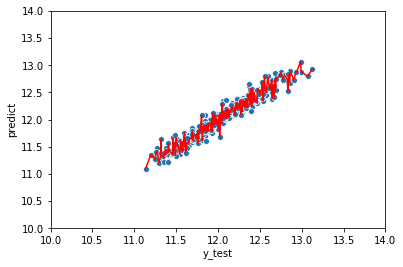

[0]	train-rmse:9.23838	valid-rmse:9.22836
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[50]	train-rmse:0.079991	valid-rmse:0.113847
[100]	train-rmse:0.062846	valid-rmse:0.109444
[150]	train-rmse:0.051988	valid-rmse:0.108699
[200]	train-rmse:0.043598	valid-rmse:0.107963
[250]	train-rmse:0.037784	valid-rmse:0.107716
[300]	train-rmse:0.032216	valid-rmse:0.107947
Stopping. Best iteration:
[239]	train-rmse:0.038778	valid-rmse:0.10724



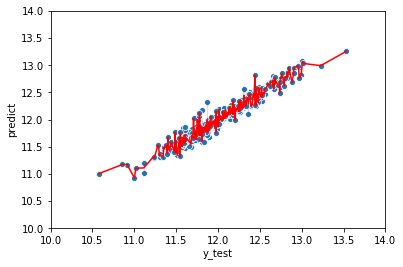

[0]	train-rmse:9.2387	valid-rmse:9.23066
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[50]	train-rmse:0.08276	valid-rmse:0.110528
[100]	train-rmse:0.06333	valid-rmse:0.104567
[150]	train-rmse:0.051791	valid-rmse:0.102879
[200]	train-rmse:0.043945	valid-rmse:0.103017
[250]	train-rmse:0.037156	valid-rmse:0.10293
[300]	train-rmse:0.031908	valid-rmse:0.102911
Stopping. Best iteration:
[219]	train-rmse:0.041145	valid-rmse:0.102562



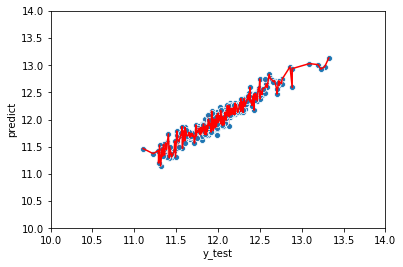

[0]	train-rmse:9.23956	valid-rmse:9.22794
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[50]	train-rmse:0.081238	valid-rmse:0.115492
[100]	train-rmse:0.063811	valid-rmse:0.112293
[150]	train-rmse:0.052615	valid-rmse:0.110674
[200]	train-rmse:0.044621	valid-rmse:0.110842
Stopping. Best iteration:
[144]	train-rmse:0.053837	valid-rmse:0.109997



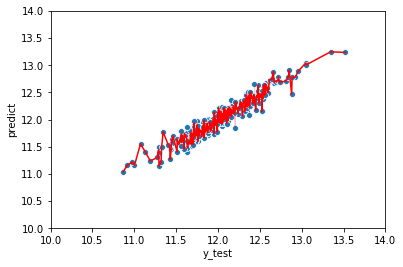

In [127]:
X=ori_train_X.values
y=ori_train_Y.values
model_=[]
badpre_=[]
gain_=[]
total_gain_=[]
importance_=[]
rmse_=[]
savenum=1
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model,badpre,rmse,gain,total_gain,importance=lear(X_train,X_test,y_train,y_test,savenum)
    model_.append(model)
    badpre_.append(badpre)
    gain_.append(gain)
    rmse_.append(rmse)
    total_gain_.append(total_gain)
    importance_.append(importance)
    savenum += 1
    

In [128]:
avg_rmse = np.array(rmse_).mean()

In [129]:
badindex=[]
for i in badpre_:
    idx_ = list(i.index.values)
    badindex=sum([badindex],idx_)

In [130]:
#第一次找到的outlier
badindex

[]

In [131]:
total_gain_[0].head(5)
total_gain_[1].head(5)
total_gain_[2].head(5)
total_gain_[3].head(5)

,feature,total_gain
1,TotalSF,70.727486
0,OverallQual,43.382221
2,ExterQual,14.160106
3,TotalBath,13.308924
7,KM3,10.112874


,feature,total_gain
1,TotalSF,63.389335
0,OverallQual,36.154287
2,KitchenQual,15.804469
5,Qual_Overall,10.703050
4,mean_TotalBath_SP,8.945838


,feature,total_gain
0,TotalSF,39.219661
1,OverallQual,37.497973
2,KitchenQual,14.023515
3,GarageCars,13.883713
6,KM3,8.699035


,feature,total_gain
1,TotalSF,75.816570
0,OverallQual,45.056327
3,TotalBath,13.863698
4,KitchenQual,11.119133
7,Qual_Bsmt,9.230301


In [132]:
importance_[0].head(5)
importance_[1].head(5)
importance_[2].head(5)
importance_[3].head(5)

,feature,importance
1,TotalSF,70
21,LotArea,67
28,BsmtUnfSF,50
5,Qual_Garagearea,49
54,1stFlrSF,47


,feature,importance
1,TotalSF,105
14,LotArea,99
36,BsmtUnfSF,68
12,YearRemodAdd,65
17,GrLivArea,62


,feature,importance
20,LotArea,100
0,TotalSF,86
43,BsmtUnfSF,73
30,Total_porch_sf,68
17,GrLivArea,63


,feature,importance
1,TotalSF,59
21,LotArea,56
23,Total_porch_sf,44
31,BsmtUnfSF,44
20,mean_LotFrontage_SP,38


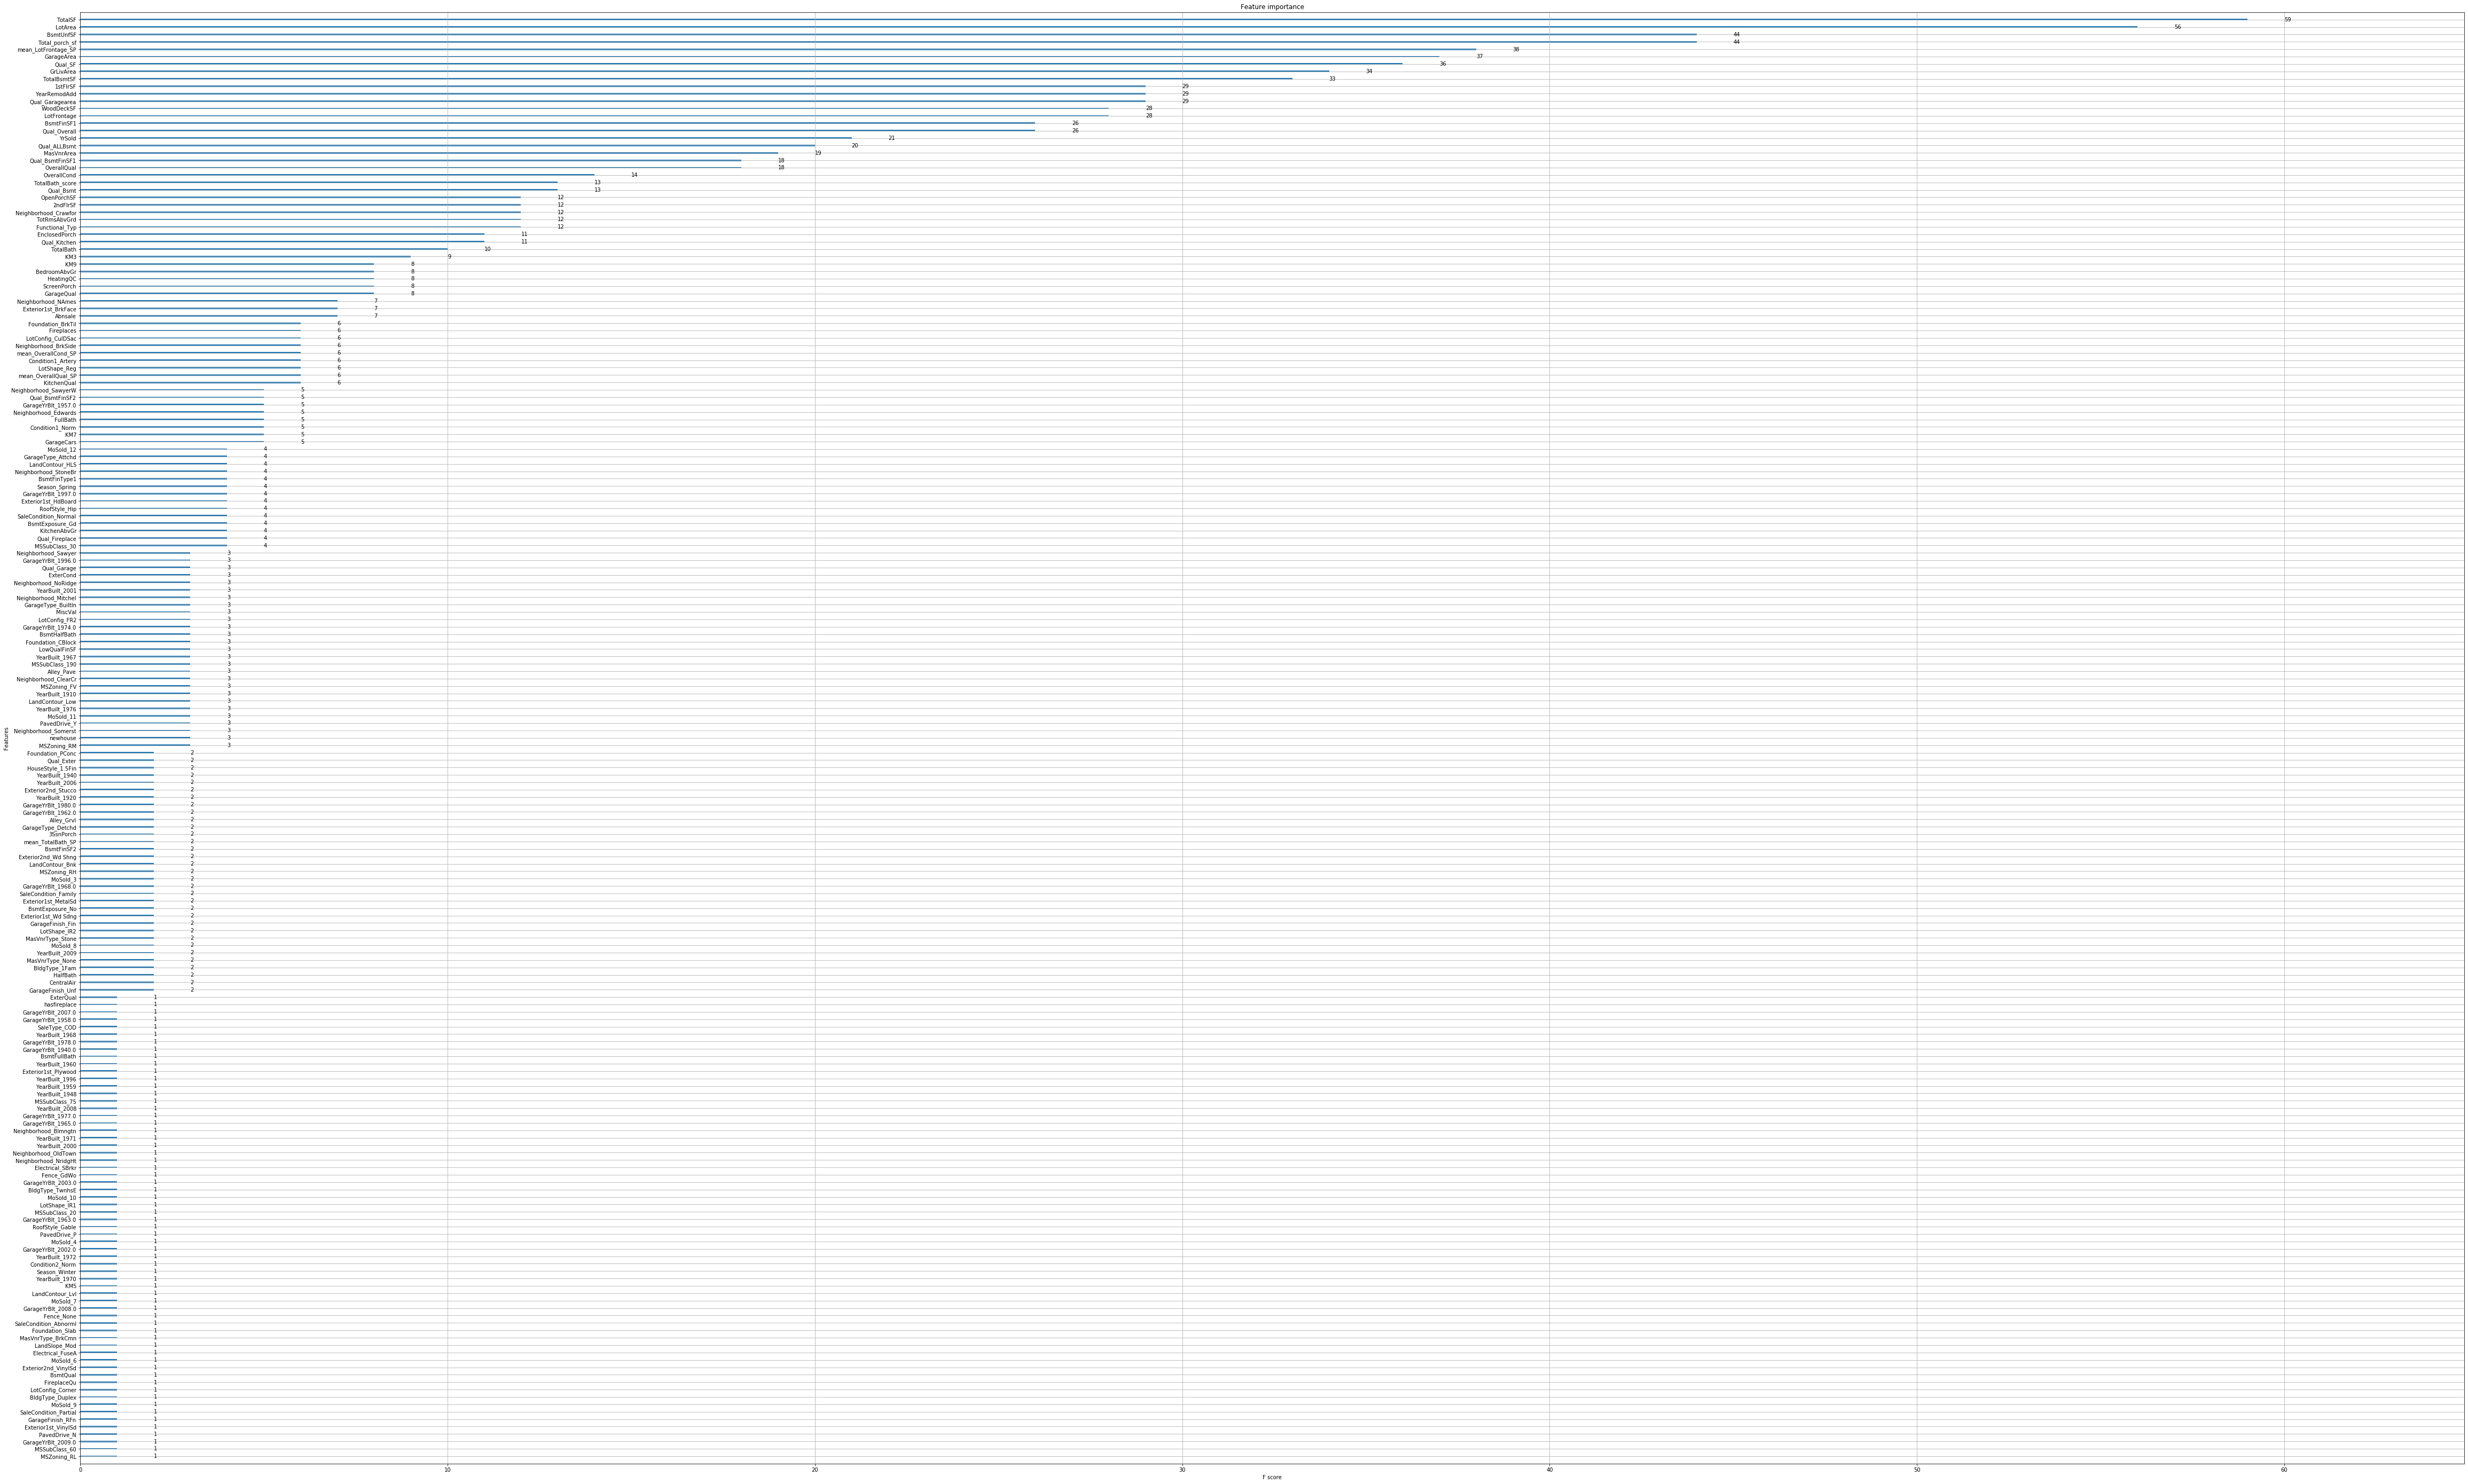

In [133]:
import matplotlib.pyplot as plt
#xgb.plot_importance(model)
fig, ax = plt.subplots(figsize=(80, 50))
xgb.plot_importance(model, ax=ax)

In [136]:
from sklearn.model_selection import train_test_split

In [64]:
xgb_pars = {'min_child_weight': 10, 'eta': 0.2, 'colsample_bytree': 0.8, 'max_depth': 3,
            'subsample': 0.9, 'lambda': 2, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'gamma' : 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'} 

In [69]:
cv_results = xgb.cv(dtrain=dtrain, params=xgb_pars, nfold=3,
                    num_boost_round=300,early_stopping_rounds=100,metrics="rmse", as_pandas=True, seed=123)

In [70]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.243122,0.006145,9.243114,0.015338
1,7.404179,0.005406,7.404168,0.016397
2,5.931840,0.005033,5.931826,0.017181
3,4.755877,0.004210,4.755857,0.018600
4,3.814372,0.003345,3.815936,0.019439
5,3.060059,0.002008,3.062154,0.020749
6,2.456773,0.002018,2.457742,0.019651
7,1.974038,0.000804,1.975098,0.021275
8,1.587519,0.000913,1.589915,0.019952
9,1.279281,0.001075,1.283734,0.018266


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [156]:
#選取最好參數一起訓練
X=ori_train_X.values
y=ori_train_Y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=feature_names)
dvalid = xgb.DMatrix(X_test, label=y_test,feature_names=feature_names)
dtest = xgb.DMatrix(ori_test_X.values,feature_names=feature_names)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
feature_names=gro_df_train.columns
final_model = xgb.train(xgb_pars, dtrain,1000, watchlist, early_stopping_rounds=10,
                  maximize=False, verbose_eval=50)
final_predict=final_model.predict(dtest, ntree_limit=model.best_ntree_limit)

[0]	train-rmse:9.24042	valid-rmse:9.23258
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[50]	train-rmse:0.080108	valid-rmse:0.112422
[100]	train-rmse:0.061739	valid-rmse:0.106645
Stopping. Best iteration:
[91]	train-rmse:0.063756	valid-rmse:0.106575



In [157]:
pred = np.expm1(final_predict)

In [158]:
ids.shape

(1459,)

In [159]:
pred.shape

(1459,)

In [160]:
sub = pd.DataFrame()
sub['Id'] = ids
sub['SalePrice'] = pred
sub.to_csv('xgb_submission.csv',index=False)